## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path    # for saving purpose

## Setup

In [2]:
train_dir = './dataset/train'
val_dir = './dataset/val'
# Not used for training
test_dir = './dataset/test'

ckpt_dir = './checkpoint/'

BATCH_SIZE = 256
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = 40

INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 20
total_epochs =  INITIAL_EPOCHS + FINE_TUNE_EPOCHS

## Load Dataset

In [3]:
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_dataset = train_gen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,class_mode='sparse')
val_dataset = val_gen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')

Found 16629 images belonging to 40 classes.
Found 2771 images belonging to 40 classes.


In [4]:
def FT_plot_graph(lr, ft_list, histories, opt_type=None):
    plt.figure(figsize=(8, 12))
    for ft_at, history in zip(ft_list, histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        for i in range(15, 20):
            print('lr: ', lr, ' ft_at: ', ft_at, ' epoch: ', i+1, ' train acc: ', acc[i], ' val acc: ', val_acc[i])
        print()

        plt.subplot(4, 1, 1)
        plt.plot(acc, label=('ft_at: %.4g\'s Training Acc') % (ft_at))
        plt.ylim([0.8, 1])
        plt.legend(loc='upper left')

        plt.subplot(4, 1, 2)
        plt.plot(val_acc, label=('ft_at: %.4g\'s Val Acc') % (ft_at))
        plt.ylim([0.7, 0.95])
        plt.legend(loc='upper left')

        plt.subplot(4, 1, 3)
        plt.plot(loss, label=('ft_at: %.4g\'s Training Loss') % (ft_at))
        plt.ylim([0, 1])
        plt.legend(loc='lower left')

        plt.subplot(4, 1, 4)
        plt.plot(val_loss, label=('ft_at: %.4g\'s Val Loss') % (ft_at))
        plt.ylim([0, 1])
        plt.legend(loc='lower left')

        plt.xlabel('epoch')
    if opt_type:
        plt.savefig('./FT_result/' + 'LR' + str(lr) + '_' + opt_type + '_FT_comparasion.png', dpi=300)
    plt.show()

## Set Fine Tune Location
* 9+: 82
* 10+: 91
* 11+: 99
* 12+: 108
* 13+: 117
* 14+: 126
* 15+: 135
* 16+: 144
* last: 152

## Fine Tune SGDM LR 0.05 Dropout 0.4

In [32]:
model = models.load_model('./TF_model_for_FT/LR0.05_TF_SGDM_04Dp_20epo.h5')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 6s 544ms/step - loss: 0.6531 - accuracy: 0.8077


[0.6530560038306497, 0.8076507]

In [ ]:
ft_list = [126, 135, 144]
sgd_LR05_histories = []
lr = 0.05
for ft_at in ft_list:
    model = models.load_model('./TF_model_for_FT/LR0.05_TF_SGDM_04Dp_20epo.h5')

    model.layers[3].trainable = True
    for layer in model.layers[3].layers[:ft_at]:
        layer.trainable = False
    sgd_histories = []
    model.compile(optimizer=optimizers.SGD(learning_rate = lr/10, momentum=0.9), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    model_name = 'LR' + str(lr) + '_FT' + str(ft_at) + '_SGDM_04Dp_20epo'

    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = FINE_TUNE_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    sgd_LR05_histories.append(history)
    model.save('./model/' + model_name + '.h5')

In [ ]:
FT_plot_graph(lr, ft_list, sgd_histories, 'SGDM_04Dp')

## Manual Select

In [24]:
model_name = 'LR0.01_FT126_SGDM_04Dp_20epo'
model = models.load_model('./model/' + model_name + '.h5')
model.evaluate(val_dataset)
model.load_weights('./checkpoint/' + model_name + '.ckpt')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 5s 484ms/step - loss: 0.5424 - accuracy: 0.8409
  ...
    to  
  ['...']
11/11 [==============================] - 5s 420ms/step - loss: 0.5018 - accuracy: 0.8502


[0.5018074918876995, 0.85023457]

In [25]:
model_dir = './FT_model/' + model_name + '.h5'
model.save(model_dir)
model = models.load_model(model_dir)
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 5s 482ms/step - loss: 0.5018 - accuracy: 0.8502


[0.5018074918876995, 0.85023457]

## Fine Tune SGDM LR 0.01 Dropout 0.4

In [37]:
model = models.load_model('./TF_model_for_FT/LR0.01_TF_SGDM_04Dp_20epo.h5')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 6s 585ms/step - loss: 0.7026 - accuracy: 0.7889


[0.7025738087567416, 0.7888849]

In [28]:
ft_list = [82, 91, 99, 108, 117, 126]
sgd_LR01_histories = []
lr = 0.01
for ft_at in ft_list:
    model = models.load_model('./TF_model_for_FT/LR0.01_TF_SGDM_04Dp_20epo.h5')

    model.layers[3].trainable = True
    for layer in model.layers[3].layers[:ft_at]:
        layer.trainable = False

    model.compile(optimizer=optimizers.SGD(learning_rate = lr/10, momentum=0.9), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    model_name = 'LR' + str(lr) + '_FT' + str(ft_at) + '_SGDM_04Dp_20epo'

    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = FINE_TUNE_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    sgd_LR01_histories.append(history)
    model.save('./model/' + model_name + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 38s - loss: 1.2402 - accuracy: 0.6292 - val_loss: 0.8335 - val_accuracy: 0.7510
Epoch 2/20
65/65 - 34s - loss: 0.9230 - accuracy: 0.7113 - val_loss: 0.7282 - val_accuracy: 0.7734
Epoch 3/20
65/65 - 35s - loss: 0.7924 - accuracy: 0.7534 - val_loss: 0.6561 - val_accuracy: 0.7950
Epoch 4/20
65/65 - 35s - loss: 0.7312 - accuracy: 0.7717 - val_loss: 0.6234 - val_accuracy: 0.8012
Epoch 5/20
65/65 - 34s - loss: 0.6639 - accuracy: 0.7944 - val_loss: 0.6434 - val_accuracy: 0.8048
Epoch 6/20
65/65 - 36s - loss: 0.6120 - accuracy: 0.8083 - val_loss: 0.6556 - val_accuracy: 0.7997
Epoch 7/20
65/65 - 35s - loss: 0.5654 - accuracy: 0.8224 - val_loss: 0.5246 - val_accuracy: 0.8365
Epoch 8/20
65/65 - 35s - loss: 0.5204 - accuracy: 0.8370 - val_loss: 0.5528 - val_accuracy: 0.8253
Epoch 9/20
65/65 - 35s - loss: 0.4888 - accuracy: 0.8470 - val_loss: 0.5372 - val_accuracy: 0.8279
Epoch 10/20
65/65

lr:  0.01  ft_at:  82  epoch:  16  train acc:  0.90011424  val acc:  0.8632263
lr:  0.01  ft_at:  82  epoch:  17  train acc:  0.90781164  val acc:  0.8614219
lr:  0.01  ft_at:  82  epoch:  18  train acc:  0.9139455  val acc:  0.86539155
lr:  0.01  ft_at:  82  epoch:  19  train acc:  0.91334414  val acc:  0.8614219
lr:  0.01  ft_at:  82  epoch:  20  train acc:  0.9221841  val acc:  0.8679177

lr:  0.01  ft_at:  91  epoch:  16  train acc:  0.8829755  val acc:  0.8401299
lr:  0.01  ft_at:  91  epoch:  17  train acc:  0.88496  val acc:  0.8412126
lr:  0.01  ft_at:  91  epoch:  18  train acc:  0.897348  val acc:  0.8444605
lr:  0.01  ft_at:  91  epoch:  19  train acc:  0.8965662  val acc:  0.86683506
lr:  0.01  ft_at:  91  epoch:  20  train acc:  0.90811235  val acc:  0.8599783

lr:  0.01  ft_at:  99  epoch:  16  train acc:  0.89109385  val acc:  0.83976907
lr:  0.01  ft_at:  99  epoch:  17  train acc:  0.89410067  val acc:  0.83904725
lr:  0.01  ft_at:  99  epoch:  18  train acc:  0.893198

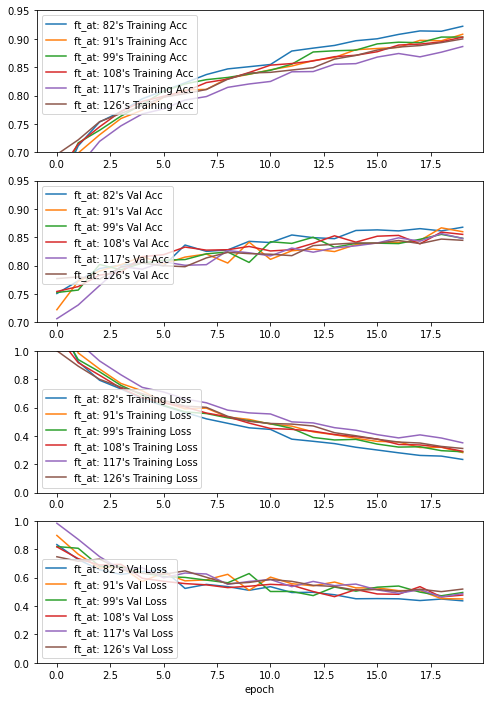

In [35]:
FT_plot_graph(lr, ft_list, sgd_LR01_histories, 'SGDM_04Dp')

## Manual Select

In [43]:
model_name = 'LR0.01_FT117_SGDM_04Dp_20epo'
model = models.load_model('./model/' + model_name + '.h5')
model.evaluate(val_dataset)
model.load_weights('./checkpoint/' + model_name + '.ckpt')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 6s 526ms/step - loss: 0.4877 - accuracy: 0.8481
  ...
    to  
  ['...']
11/11 [==============================] - 5s 433ms/step - loss: 0.4649 - accuracy: 0.8567


[0.46485136313871905, 0.8567304]

In [44]:
model_dir = './FT_model/' + model_name + '.h5'
model.save(model_dir)
model = models.load_model(model_dir)
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 6s 513ms/step - loss: 0.4649 - accuracy: 0.8567


[0.46485136313871905, 0.8567304]

## Fine Tune ADAM LR 0.001 Dropout 0.4

In [5]:
model = models.load_model('./TF_model_for_FT/LR0.001_TF_ADAM_04Dp_20epo.h5')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 13s 1s/step - loss: 0.6305 - accuracy: 0.8069


[0.6304991516199979, 0.80692893]

In [6]:
ft_list = [82, 91, 99, 108, 117, 126]
adam_histories = []
lr = 0.001
for ft_at in ft_list:
    model = models.load_model('./TF_model_for_FT/LR0.001_TF_ADAM_04Dp_20epo.h5')
    
    model.layers[3].trainable = True
    for layer in model.layers[3].layers[:ft_at]:
        layer.trainable = False
    
    model.compile(optimizer=optimizers.Adam(learning_rate = lr/10), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    model_name = 'LR' + str(lr) + '_FT' + str(ft_at) + '_ADAM_04Dp_20epo'

    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = FINE_TUNE_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    adam_histories.append(history)
    model.save('./model/' + model_name + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 40s - loss: 0.6691 - accuracy: 0.7892 - val_loss: 0.5840 - val_accuracy: 0.8141
Epoch 2/20
65/65 - 33s - loss: 0.4824 - accuracy: 0.8462 - val_loss: 0.5513 - val_accuracy: 0.8275
Epoch 3/20
65/65 - 33s - loss: 0.3870 - accuracy: 0.8745 - val_loss: 0.5272 - val_accuracy: 0.8437
Epoch 4/20
65/65 - 33s - loss: 0.3318 - accuracy: 0.8912 - val_loss: 0.5235 - val_accuracy: 0.8419
Epoch 5/20
65/65 - 34s - loss: 0.2782 - accuracy: 0.9096 - val_loss: 0.5228 - val_accuracy: 0.8423
Epoch 6/20
65/65 - 33s - loss: 0.2417 - accuracy: 0.9210 - val_loss: 0.5287 - val_accuracy: 0.8524
Epoch 7/20
65/65 - 33s - loss: 0.2073 - accuracy: 0.9311 - val_loss: 0.5253 - val_accuracy: 0.8510
Epoch 8/20
65/65 - 31s - loss: 0.1795 - accuracy: 0.9416 - val_loss: 0.5083 - val_accuracy: 0.8556
Epoch 9/20
65/65 - 32s - loss: 0.1518 - accuracy: 0.9488 - val_loss: 0.5069 - val_accuracy: 0.8636
Epoch 10/20
65/65

lr:  0.001  ft_at:  82  epoch:  16  train acc:  0.97444224  val acc:  0.861061
lr:  0.001  ft_at:  82  epoch:  17  train acc:  0.9769078  val acc:  0.8690004
lr:  0.001  ft_at:  82  epoch:  18  train acc:  0.98322207  val acc:  0.8693612
lr:  0.001  ft_at:  82  epoch:  19  train acc:  0.9821998  val acc:  0.8693612
lr:  0.001  ft_at:  82  epoch:  20  train acc:  0.9850863  val acc:  0.8585348

lr:  0.001  ft_at:  91  epoch:  16  train acc:  0.97498345  val acc:  0.85925657
lr:  0.001  ft_at:  91  epoch:  17  train acc:  0.9813579  val acc:  0.8585348
lr:  0.001  ft_at:  91  epoch:  18  train acc:  0.9813579  val acc:  0.870083
lr:  0.001  ft_at:  91  epoch:  19  train acc:  0.9813579  val acc:  0.8567304
lr:  0.001  ft_at:  91  epoch:  20  train acc:  0.980095  val acc:  0.8693612

lr:  0.001  ft_at:  99  epoch:  16  train acc:  0.9747429  val acc:  0.86503065
lr:  0.001  ft_at:  99  epoch:  17  train acc:  0.9725179  val acc:  0.8570913
lr:  0.001  ft_at:  99  epoch:  18  train acc:  

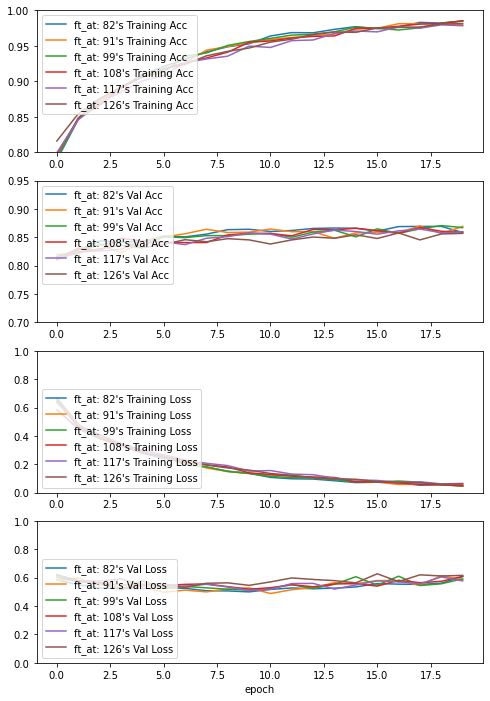

In [11]:
FT_plot_graph(lr, ft_list, adam_histories, 'ADAM_04Dp')

In [12]:
ft_list = [82, 91, 99, 108]
adam_m_histories = []
lr = 0.001
for ft_at in ft_list:
    model = models.load_model('./TF_model_for_FT/LR0.001_TF_ADAM_04Dp_20epo.h5')
    
    model.layers[3].trainable = True
    for layer in model.layers[3].layers[:ft_at]:
        layer.trainable = False
    
    model.compile(optimizer=optimizers.Adam(learning_rate = lr/10), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    model_name = 'LR' + str(lr) + '_FT' + str(ft_at) + '_ADAM_04Dp_20epo'

    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = FINE_TUNE_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    adam_m_histories.append(history)
    model.save('./model/' + model_name + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 35s - loss: 0.7064 - accuracy: 0.7783 - val_loss: 0.5915 - val_accuracy: 0.8228
Epoch 2/20
65/65 - 31s - loss: 0.4666 - accuracy: 0.8505 - val_loss: 0.5868 - val_accuracy: 0.8160
Epoch 3/20
65/65 - 31s - loss: 0.3941 - accuracy: 0.8744 - val_loss: 0.5271 - val_accuracy: 0.8376
Epoch 4/20
65/65 - 31s - loss: 0.3202 - accuracy: 0.8946 - val_loss: 0.5059 - val_accuracy: 0.8445
Epoch 5/20
65/65 - 31s - loss: 0.2830 - accuracy: 0.9050 - val_loss: 0.5631 - val_accuracy: 0.8336
Epoch 6/20
65/65 - 31s - loss: 0.2426 - accuracy: 0.9204 - val_loss: 0.4932 - val_accuracy: 0.8484
Epoch 7/20
65/65 - 31s - loss: 0.1972 - accuracy: 0.9355 - val_loss: 0.5482 - val_accuracy: 0.8466
Epoch 8/20
65/65 - 32s - loss: 0.1703 - accuracy: 0.9435 - val_loss: 0.4926 - val_accuracy: 0.8575
Epoch 9/20
65/65 - 31s - loss: 0.1563 - accuracy: 0.9466 - val_loss: 0.5186 - val_accuracy: 0.8564
Epoch 10/20
65/65

## Manual Select

In [12]:
model_name = 'LR0.001_FT108_ADAM_04Dp_20epo'
model = models.load_model('./model/' + model_name + '.h5')
model.evaluate(val_dataset)
model.load_weights('./checkpoint/' + model_name + '.ckpt')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 6s 545ms/step - loss: 0.6131 - accuracy: 0.8556
  ...
    to  
  ['...']
11/11 [==============================] - 5s 474ms/step - loss: 0.5160 - accuracy: 0.8712


[0.5159550932320681, 0.87116563]

In [14]:
model_dir = './FT_model/' + model_name + '.h5'
model.save(model_dir)
model = models.load_model(model_dir)
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 5s 465ms/step - loss: 0.5209 - accuracy: 0.8712


[0.5208928855982694, 0.87116563]

## Final SGDM (because some models didn't converge within 20 itr)

In [6]:
model_list = ['LR0.01_FT82_SGDM_04Dp_20epo', 'LR0.01_FT91_SGDM_04Dp_20epo', 'LR0.01_FT108_SGDM_04Dp_20epo', 'LR0.01_FT117_SGDM_04Dp_20epo']
histories = []
for model_name in model_list:
    full_path = './FT_model/' + model_name + '.h5'
    model = models.load_model(full_path)
    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = FINE_TUNE_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    histories.append(history)
    model.save('./FT40_model/' + model_name + '.h5')


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 47s - loss: 0.2121 - accuracy: 0.9309 - val_loss: 0.4659 - val_accuracy: 0.8686
Epoch 2/20
65/65 - 32s - loss: 0.2033 - accuracy: 0.9335 - val_loss: 0.5214 - val_accuracy: 0.8564
Epoch 3/20
65/65 - 33s - loss: 0.2009 - accuracy: 0.9329 - val_loss: 0.4572 - val_accuracy: 0.8625
Epoch 4/20
65/65 - 34s - loss: 0.1972 - accuracy: 0.9355 - val_loss: 0.4879 - val_accuracy: 0.8585
Epoch 5/20
65/65 - 34s - loss: 0.1654 - accuracy: 0.9463 - val_loss: 0.4447 - val_accuracy: 0.8715
Epoch 6/20
65/65 - 33s - loss: 0.1628 - accuracy: 0.9464 - val_loss: 0.4870 - val_accuracy: 0.8683
Epoch 7/20
65/65 - 31s - loss: 0.1507 - accuracy: 0.9518 - val_loss: 0.4686 - val_accuracy: 0.8712
Epoch 8/20
65/65 - 32s - loss: 0.1473 - accuracy: 0.9521 - val_loss: 0.4725 - val_accuracy: 0.8690
Epoch 9/20
65/65 - 32s - loss: 0.1580 - accuracy: 0.9483 - val_loss: 0.4483 - val_accuracy: 0.8701
Epoch 10/20
65/65

lr:  0.01  ft_at:  82  epoch:  16  train acc:  0.9708942  val acc:  0.8812703
lr:  0.01  ft_at:  82  epoch:  17  train acc:  0.9743821  val acc:  0.8754962
lr:  0.01  ft_at:  82  epoch:  18  train acc:  0.97660714  val acc:  0.8794659
lr:  0.01  ft_at:  82  epoch:  19  train acc:  0.9751639  val acc:  0.8783833
lr:  0.01  ft_at:  82  epoch:  20  train acc:  0.97750914  val acc:  0.8758571

lr:  0.01  ft_at:  91  epoch:  16  train acc:  0.9497264  val acc:  0.86358714
lr:  0.01  ft_at:  91  epoch:  17  train acc:  0.9574839  val acc:  0.87477446
lr:  0.01  ft_at:  91  epoch:  18  train acc:  0.9645198  val acc:  0.87152654
lr:  0.01  ft_at:  91  epoch:  19  train acc:  0.96596307  val acc:  0.8740527
lr:  0.01  ft_at:  91  epoch:  20  train acc:  0.9708341  val acc:  0.8628654

lr:  0.01  ft_at:  108  epoch:  16  train acc:  0.9483433  val acc:  0.86394805
lr:  0.01  ft_at:  108  epoch:  17  train acc:  0.951771  val acc:  0.8599783
lr:  0.01  ft_at:  108  epoch:  18  train acc:  0.9539

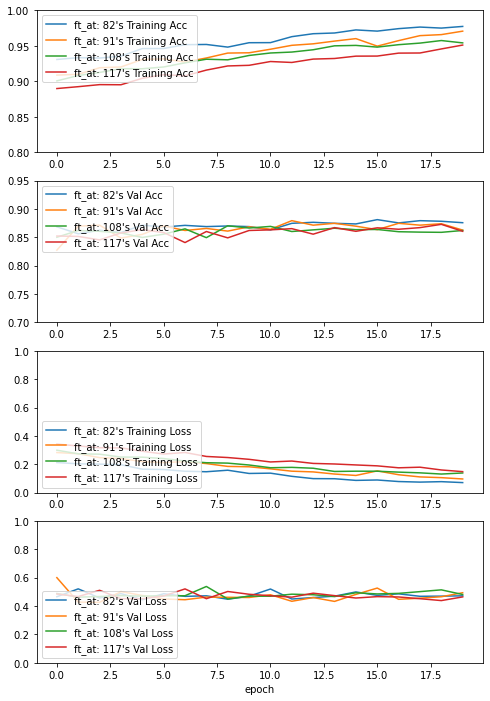

In [7]:
lr = 0.01
ft_list = [82, 91, 108, 117]
FT_plot_graph(lr, ft_list, histories, 'SGDM_04Dp_Final')

In [9]:
model_name = 'LR0.01_FT82_SGDM_04Dp_20epo'
model = models.load_model('./FT_model/' + model_name + '.h5')
model.evaluate(val_dataset)
model.load_weights('./checkpoint/' + model_name + '.ckpt')
model.evaluate(val_dataset)

  ...
    to  
  ['...']
11/11 [==============================] - 6s 521ms/step - loss: 0.4723 - accuracy: 0.8759
  ...
    to  
  ['...']
11/11 [==============================] - 5s 433ms/step - loss: 0.4447 - accuracy: 0.8715


[0.4447111270644448, 0.87152654]

In [ ]:
model_dir = './Final_model/' + model_name + '.h5'
model.save(model_dir)
model = models.load_model(model_dir)
model.evaluate(val_dataset)